Yellow cabs in NYC are perhaps one of the most recognizable icons in the city. Tens of thousands of commuters in NYC rely on taxis as a mode of transportation around the bustling metropolis. In recent years, the taxi industry in NYC has been put under increasing pressure from ride-hailing apps such as Uber.

In order to rise to the challenge from ride-hailing apps, yellow cabs in NYC are looking to modernize their operations, and to provide a user experience on par with Uber. In August 2018, the Taxi and Limousine Commission of NYC launched a new app that allows commuters to book a yellow cab from their phones. The app provides fare pricing upfront before they hail a cab. Creating an algorithm to provide fare pricing upfront is no simple feat. The algorithm needs to consider various environmental variables such as traffic conditions, time of day, and pick up and drop off locations in order to make an accurate fare prediction. The best way to do that is to leverage machine learning.

# Technical requirements
The key Python libraries required for this chapter are as follows:

matplotlib 3.0.2

pandas 0.23.4

Keras 2.2.4

NumPy 1.15.2

scikit-learn 0.20.2

In [36]:
#### Import neccessary libray

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Exploratory data analysis**

In [3]:
##### load the data set
df = pd.read_csv('/content/NYC TAXI FARE .csv', parse_dates=['pickup_datetime'], nrows=600000)

In [4]:
##### Print the 5 first rows

df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


We can see that there are eight columns in the dataset:

key: This column seems identical to the pickup_datetime column. It was probably used as an unique identifier in the database it was stored in. We can safely remove this column without any loss of information.

fare_amount: This is the target variable we are trying to predict, the fare amount paid at the end of the trip.

pickup_datetime: This column contains information on the pickup date (year, month, day of month), as well as the time (hour, minute, seconds).

pickup_longitude and pickup_latitude: The longitude and latitude of the pickup location.

dropoff_longitude and dropoff_latitude: The longitude and latitude of the drop off location.

passenger_count: The number of passengers.

# *Visualizing geolocation data*
The pick-up and drop-off longitude and latitude data are crucial to predicting the fare amount. After all, fares in NYC taxis are largely determined by the distance traveled.

In [5]:
### First, let's restrict our data points to only pickups and drop offs within NYC. NYC has an approximate longitude range of -74.05 to -73.75
##### and a latitude range of 40.63 to 40.85:

# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

df2 = df.copy(deep=True)
for long in ['pickup_longitude', 'dropoff_longitude']:
    df2 = df2[(df2[long] > nyc_min_longitude) & (df2[long] <
                                                 nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df2 = df2[(df2[lat] > nyc_min_latitude) & (df2[lat] <
                                               nyc_max_latitude)]

In [6]:
####  Now, let's define a new function that will take our DataFrame as an input,
#### and plot the pickup locations on a scatterplot. We are also interested in overlaying the scatterplot with a few key landmarks in NYC. A quick Google search tells us that there are two main airports in NYC (JFK and LaGuardia),
##### and their coordinates, along with the main districts in NYC, are as follows:


landmarks = {'JFK Airport': (-73.78, 40.643),
             'Laguardia Airport': (-73.87, 40.77),
             'Midtown': (-73.98, 40.76),
             'Lower Manhattan': (-74.00, 40.72),
             'Upper Manhattan': (-73.94, 40.82),
             'Brooklyn': (-73.95, 40.66)}

In [ ]:
#### And here's our function using matplotlib to plot the pickup locations on a scatterplot:

import matplotlib.pyplot as plt

def plot_lat_long(df, landmarks, points='Pickup'):
    plt.figure(figsize = (12,12)) # set figure size
    if points == 'pickup':
        plt.plot(list(df.pickup_longitude), list(df.pickup_latitude),
                 '.', markersize=1)
    else:
        plt.plot(list(df.dropoff_longitude), list(df.dropoff_latitude),
                 '.', markersize=1)

    for landmark in landmarks:
        plt.plot(landmarks[landmark][0], landmarks[landmark][1],
                '*', markersize=15, alpha=1, color='r')
        plt.annotate(landmark, (landmarks[landmark][0]+0.005,
                     landmarks[landmark][1]+0.005), color='r',
                     backgroundcolor='w')

    plt.title("{} Locations in NYC Illustrated".format(points))
    plt.grid(None)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()

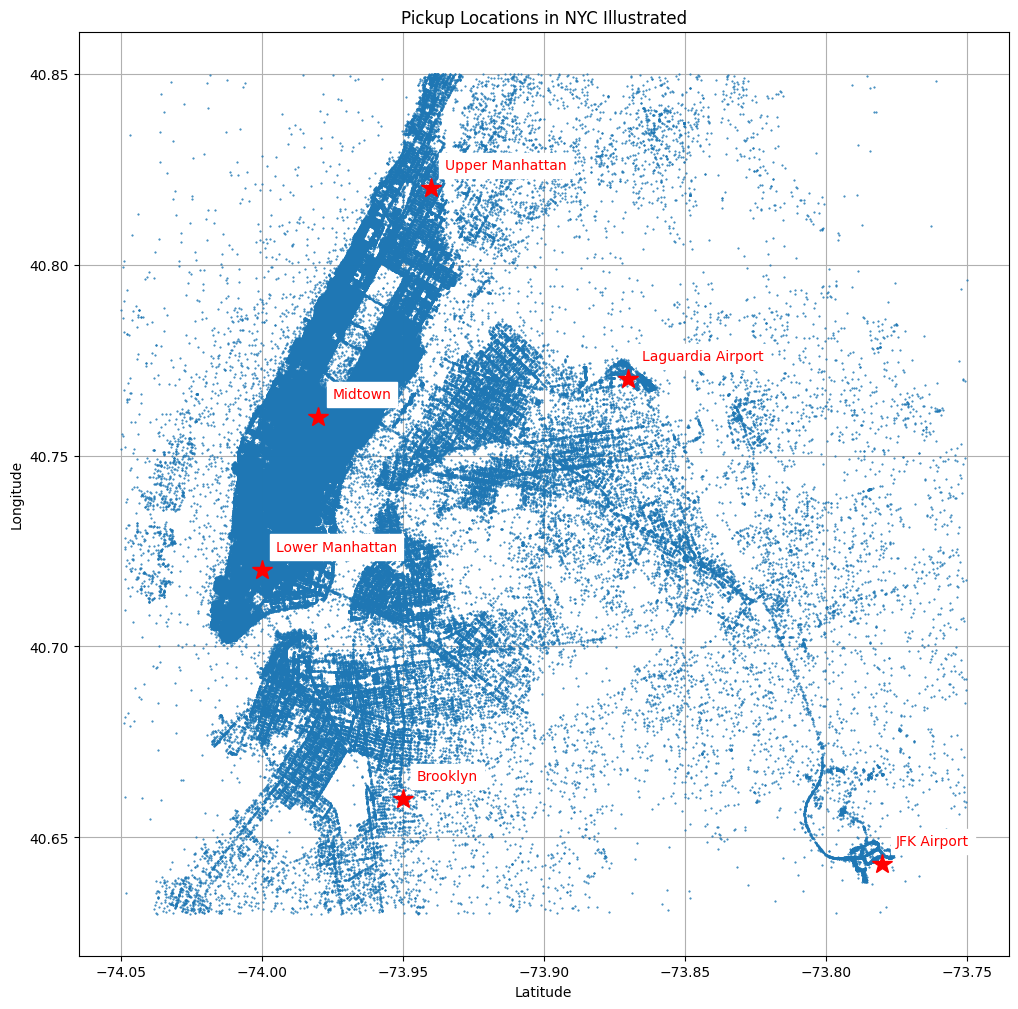

In [ ]:
### Let's run the function we just defined:
plot_lat_long(df2, landmarks, points='Pickup')

we can make a few observations:

- In Manhattan, most pickups were around the Midtown area, followed by Lower Manhattan. In comparison, there are much fewer pickups in Upper Manhattan. This makes sense, since Upper Manhattan is a residential area, whereas more offices and tourist attractions are located at Midtown and Lower Manhattan.

- Pickups are sparse outside Manhattan. The only two outliers were at LaGuardia Airport and JFK Airport.

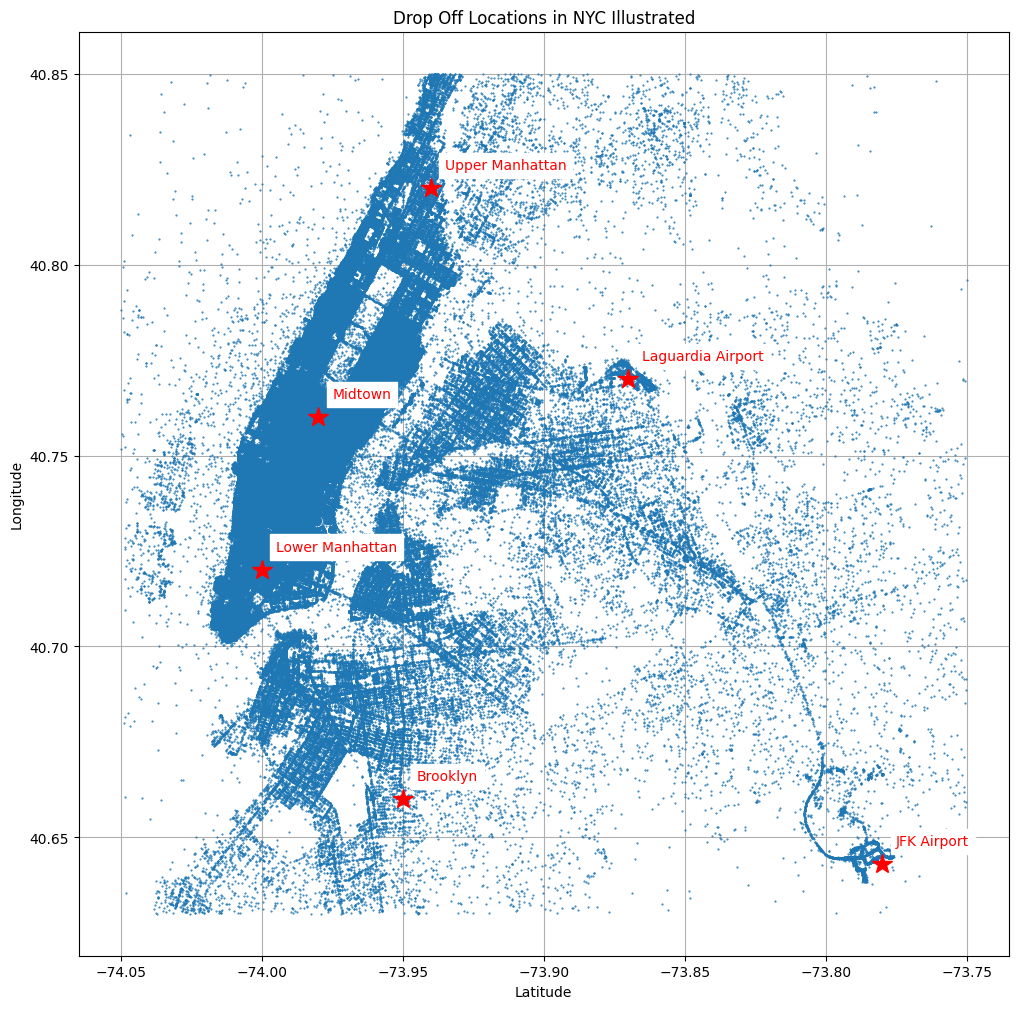

In [ ]:
### Let's also plot the scatterplot for drop off locations and see how it differs:

plot_lat_long(df2, landmarks, points='Drop Off')

Comparing the pickup and drop off scatterplots, we can clearly see that there are more drop offs than pickups in residential areas such as Upper Manhattan and Brooklyn. Neat!

# Ridership by day and hour
Next, let's investigate how the number of rides varies by day and hour.

Recall that the raw data contains a single pickup_datetime column that contains the pickup date and time in datetime format. First, let's separate the pickup year, month, day, day of week, and hour from the original pickup_datetime column into different columns

In [7]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

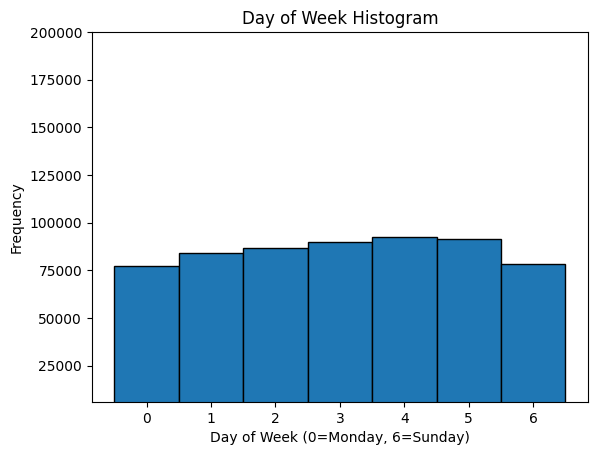

In [8]:
#### let's plot a histogram to analyze the distribution of rides throughout the week:


df['day_of_week'].plot.hist(bins=np.arange(8)-0.5, ec='black',
                            ylim=(6000,200000))
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.title('Day of Week Histogram')
plt.show()

we can see that the number of rides is not evenly distributed across each weekday. Instead, the number of rides increases linearly from Monday through Friday, and peaking on Friday. The weekends see a slight drop in the number of rides on Saturday, before falling sharply on Sunday.

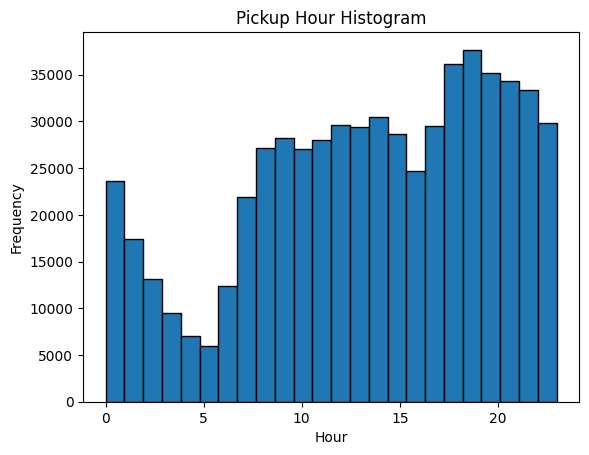

In [9]:
### lets also visualize ridership by hour:

df['hour'].plot.hist(bins=24, ec='black')
plt.title('Pickup Hour Histogram')
plt.xlabel('Hour')
plt.show()

We can see that there are more rides during the evening rush hour, as compared to the morning rush hour. In fact, the number of rides is pretty constant throughout the day. Starting at 6 P.M., the number of rides increases and peaks at 7 P.M., before falling from 11 P.M. onwards.

# **Data preprocessing**

In [10]:
##### Let's do a check to see whether there are any missing values in our dataset:

print(df.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    8
dropoff_latitude     8
passenger_count      0
year                 0
month                0
day                  0
day_of_week          0
hour                 0
dtype: int64


We can see that there are only 10 rows (out of 2000,000 rows) with missing data. With a missing data percentage of just 0.00002%, it seems that we don't have a problem with missing data. Let's go ahead and remove those five rows with missing data:

In [11]:
df = df.dropna()

In [12]:
##### Let's run a quick statistical summary on our data to look at the distribution:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour
count,599992.000000,599992.000000,599992.000000,599992.000000,599992.000000,599992.000000,599992.000000,599992.000000,599992.000000,599992.000000,599992.000000
mean,11.345079,-72.527260,39.922197,-72.522891,39.913588,1.683762,2011.739192,6.269142,15.693293,3.040157,13.510580
std,9.862574,12.413147,7.816459,11.592995,8.307124,1.307354,1.860248,3.435948,8.680353,1.949754,6.511604
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992037,40.734962,-73.991392,40.734054,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.981781,40.752707,-73.980142,40.753149,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.967095,40.767108,-73.963623,40.768127,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000
max,500.000000,2140.601160,1703.092772,40.851027,405.650000,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000


The lowest fare in the dataset is $-44.90. That doesn't make sense; fares can't be negative! Also, the highest fare is $500. Did the passenger get ripped off? Or was it just an error? Let's plot a histogram to better understand the distribution of fares:

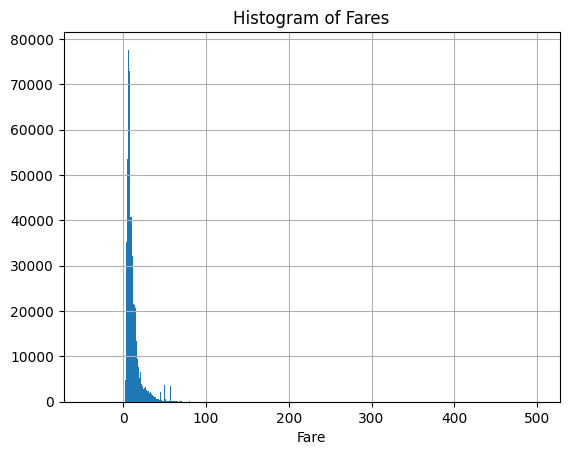

In [13]:
df['fare_amount'].hist(bins=500)
plt.xlabel("Fare")
plt.title("Histogram of Fares")
plt.show()

It doesn't seem like that there are too many outliers, so we can safely remove them. Another interesting trend that we can observe from the histogram is that there is a small spike in fares around $50. Could this be a fixed fare from a specific location? Cities usually implement fixed fares for trips to and from airports. A quick Google search tells us that trips to and from JFK airport incurs a flat fare of $52 plus tolls. This could be the reason for the spike in the histogram around $50! We'll keep this important fact in mind when we do feature engineering later on.

In [14]:
#### let's remove rows with fares less than $0 and more than $100:

df = df[(df['fare_amount'] >=0) & (df['fare_amount'] <= 100)]

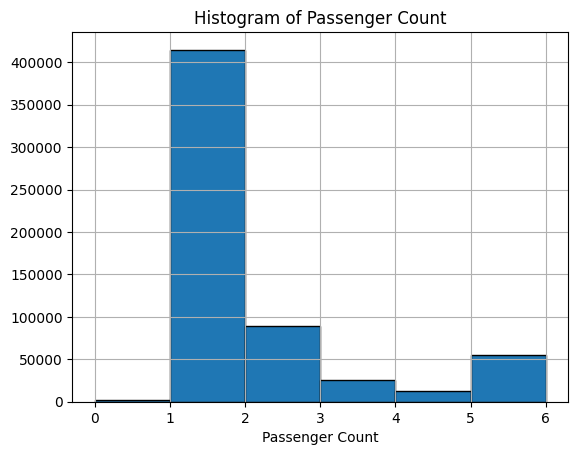

In [15]:
#### Let's plot a histogram of Passenger Count to look at its distribution:

df['passenger_count'].hist(bins=6, ec='black')
plt.xlabel("Passenger Count")
plt.title("Histogram of Passenger Count")
plt.show()

We can see that there's a small percentage of rows with 0 passenger counts.

In [16]:
### let's replace the outliers with the mode (that is, 1 passenger count):

df.loc[df['passenger_count']==0, 'passenger_count'] = 1

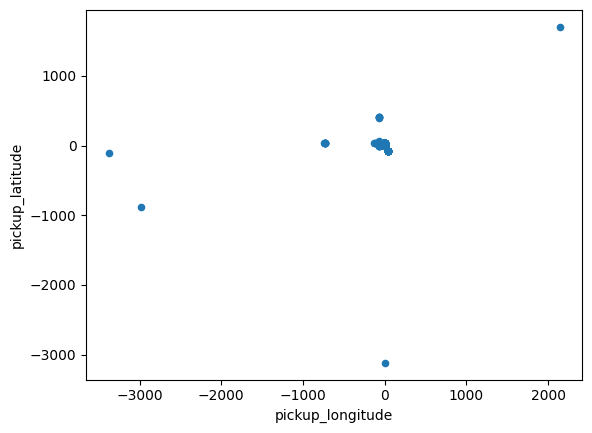

In [17]:
##### let's inspect the pickup and drop off latitude and longitude data to check for outliers.
df.plot.scatter('pickup_longitude', 'pickup_latitude')
plt.show()


The dots at the periphery of the scatterplot are outliers. They have latitude values as high as 1000 and as low as -3000. Earth's geographic coordinate system does not have such extreme latitudes and longitudes!

In [18]:
#### Let's remove these outliers:

# range of longitude for NYC
nyc_min_longitude = -74.05
nyc_max_longitude = -73.75

# range of latitude for NYC
nyc_min_latitude = 40.63
nyc_max_latitude = 40.85

# only consider locations within NYC
for long in ['pickup_longitude', 'dropoff_longitude']:
    df = df[(df[long] > nyc_min_longitude) & (df[long] <
                                              nyc_max_longitude)]

for lat in ['pickup_latitude', 'dropoff_latitude']:
    df = df[(df[lat] > nyc_min_latitude) & (df[lat] <
                                            nyc_max_latitude)]

# Feature engineering

**Temporal features**

In [19]:
#### Let's look at the format of the pickup_datetime column by running the following code:

print(df.head(20)['pickup_datetime'])

0    2009-06-15 17:26:21+00:00
1    2010-01-05 16:52:16+00:00
2    2011-08-18 00:35:00+00:00
3    2012-04-21 04:30:42+00:00
4    2010-03-09 07:51:00+00:00
5    2011-01-06 09:50:45+00:00
6    2012-11-20 20:35:00+00:00
7    2012-01-04 17:22:00+00:00
8    2012-12-03 13:10:00+00:00
9    2009-09-02 01:11:00+00:00
10   2012-04-08 07:30:50+00:00
12   2009-11-06 01:04:03+00:00
13   2013-07-02 19:54:00+00:00
14   2011-04-05 17:11:05+00:00
16   2014-02-19 07:22:00+00:00
17   2009-07-22 16:08:00+00:00
18   2010-07-07 14:52:00+00:00
19   2014-12-06 20:36:22+00:00
20   2010-09-07 13:18:00+00:00
21   2013-02-12 12:15:46+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]


we can't train our neural network using such a datetime string. Let's separate the pickup_datetime column into different columns for year, month, day, day_of_week, and hour:

In [20]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

#####Let's take a look at the new columns:

print(df.loc[:20,['pickup_datetime', 'year', 'month',
                 'day', 'day_of_week', 'hour']])

             pickup_datetime  year  month  day  day_of_week  hour
0  2009-06-15 17:26:21+00:00  2009      6   15            0    17
1  2010-01-05 16:52:16+00:00  2010      1    5            1    16
2  2011-08-18 00:35:00+00:00  2011      8   18            3     0
3  2012-04-21 04:30:42+00:00  2012      4   21            5     4
4  2010-03-09 07:51:00+00:00  2010      3    9            1     7
5  2011-01-06 09:50:45+00:00  2011      1    6            3     9
6  2012-11-20 20:35:00+00:00  2012     11   20            1    20
7  2012-01-04 17:22:00+00:00  2012      1    4            2    17
8  2012-12-03 13:10:00+00:00  2012     12    3            0    13
9  2009-09-02 01:11:00+00:00  2009      9    2            2     1
10 2012-04-08 07:30:50+00:00  2012      4    8            6     7
12 2009-11-06 01:04:03+00:00  2009     11    6            4     1
13 2013-07-02 19:54:00+00:00  2013      7    2            1    19
14 2011-04-05 17:11:05+00:00  2011      4    5            1    17
16 2014-02

We can see that the new columns capture the original information from the pickup_datetime column in a format that's suitable for our neural network.

In [21]:
####Let's drop the pickup_datetime column from our DataFrame:

df = df.drop(['pickup_datetime'], axis=1)

*Geolocation features*

The dataset contains information regarding the pickup and drop off coordinates. However, there is no information regarding the distance between the pickup and drop off points, which is arguably the most important factor in deciding taxi fares.

In [22]:
### let's create a new feature that calculates the distance between each pair of pickup and drop off points
##### Let's define a function to calculate the Euclidean distance between any two points, given the latitude and longitudes of the two points:

def euc_distance(lat1, long1, lat2, long2):
    return(((lat1-lat2)**2 + (long1-long2)**2)**0.5)

In [23]:
##### let's apply the function to the DataFrame to create the new distance column:

df['distance'] = euc_distance(df['pickup_latitude'],
                              df['pickup_longitude'],
                              df['dropoff_latitude'],
                              df['dropoff_longitude'])

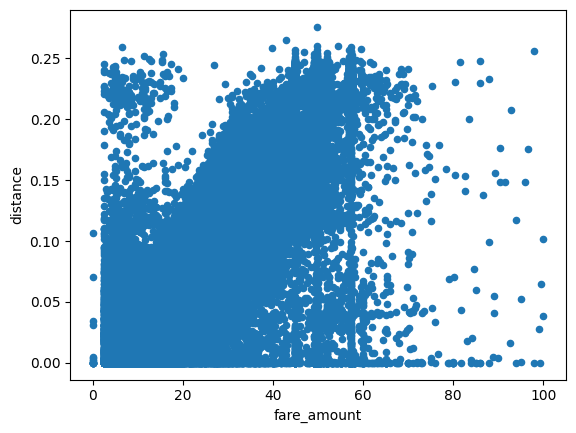

In [24]:
##### We can now plot the two variables on a scatterplot to analyze the correlation and see if our intuition was right:

df.plot.scatter('fare_amount', 'distance')
plt.show()

We can clearly see that our hypothesis is right. However, the distance traveled alone does not tell the whole story. If we look at the center of the graph, we can see three vertical lines of dots. These outlier data seems to suggest that there are certain trips where the distance traveled did not have an impact on the fare amount (which is between $40 and $60 for these outliers). Recall in the previous section on data visualization where we saw that there are certain pickups near airports, and these airport pickups have a flat fare of $52 plus tolls. This could explain the three vertical lines of dots between $40 and $60!

Clearly, we need to engineer a new feature that informs our neural network of the pickup and drop off distance from the three major airports in NYC. When we train the neural network on this feature, it should then learn that pickups and drop offs near airports have a flat fare between $40 and $60.

In [25]:
#### We can use the euc_distance function that we defined earlier to calculate the pickup and drop off distance from the three major airports in NYC:

airports = {'JFK_Airport': (-73.78,40.643),
            'Laguardia_Airport': (-73.87, 40.77),
            'Newark_Airport' : (-74.18, 40.69)}

for airport in airports:
    df['pickup_dist_' + airport] = euc_distance(df['pickup_latitude'],
                                                df['pickup_longitude'],
                                                airports[airport][1],
                                                airports[airport][0])
    df['dropoff_dist_' + airport] = euc_distance(df['dropoff_latitude'],
                                                 df['dropoff_longitude'],
                                                 airports[airport][1],
                                                 airports[airport][0])

In [26]:
### Let's print out the first few rows, along with a few relevant columns to verify that the Euclidean distance function is functioning as intended:

print(df[['key', 'pickup_longitude', 'pickup_latitude',
          'dropoff_longitude', 'dropoff_latitude',
          'pickup_dist_JFK_Airport',
          'dropoff_dist_JFK_Airport']].head())

       key  pickup_longitude  pickup_latitude  dropoff_longitude  \
0  26:21.0        -73.844311        40.721319         -73.841610   
1  52:16.0        -74.016048        40.711303         -73.979268   
2  35:00.0        -73.982738        40.761270         -73.991242   
3  30:42.0        -73.987130        40.733143         -73.991567   
4  51:00.0        -73.968095        40.768008         -73.956655   

   dropoff_latitude  pickup_dist_JFK_Airport  dropoff_dist_JFK_Airport  
0         40.712278                 0.101340                  0.092710  
1         40.782004                 0.245731                  0.242961  
2         40.750562                 0.234714                  0.237050  
3         40.758092                 0.225895                  0.240846  
4         40.783762                 0.225847                  0.225878  


We notice that there is still a key column in the dataset. This column is similar to the pickup_datetime column, and it was probably used as a unique identifier in the database it was stored in. We can safely remove this column without any loss of information.

In [27]:
df = df.drop(['key'], axis=1)

#Feature scaling

Before we scale the features in the DataFrame, it's a good idea to keep a copy of the prescaled DataFrame. The values of the features will be transformed after scaling , which can make it difficult for us to interpret the values. By keeping a copy of the prescaled DataFrame, we can easily reference the original values:

In [28]:
df_prescaled = df.copy()

We should also drop the fare_amount target variable before scaling, as we do not want to modify the target variable:

In [29]:
df_scaled = df.drop(['fare_amount'], axis=1)

In [30]:
 #### Lets scale the features by calling the scale function from scikit-learn:

from sklearn.preprocessing import scale

df_scaled = scale(df_scaled)

In [32]:
##### convert the object returned by the scale function into a pandas DataFrame and
###### concatenate the original fare_amount column that was dropped before scaling:

cols = df.columns.tolist()
cols.remove('fare_amount')
df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df.index)
df_scaled = pd.concat([df_scaled, df['fare_amount']], axis=1)
df = df_scaled.copy()

#Model building using Keras

In [33]:
#### First, split the DataFrame into the training features (X) and the target variable that we're trying to predict (y):

X = df.loc[:, df.columns != 'fare_amount']
y = df.loc[:, 'fare_amount']

In [37]:
##### Then, split the data into a training set (80%) and a testing set (20%):



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
#### Now, let's build our Sequential model in Keras according to the neural network architecture we outlined earlier:



model = Sequential()
model.add(Dense(128, activation= 'relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(32, activation= 'relu'))
model.add(Dense(8, activation= 'relu'))
model.add(Dense(1))

In [39]:
 ### lets verify the structure of our model:

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               2304      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 8)                 264       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 12913 (50.44 KB)
Trainable params: 12913 (50.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
### we can compile and train our neural network on the training data:

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(X_train, y_train, epochs=1)

14506/14506 [==============================] - 58s 4ms/step - loss: 13.5938 - mse: 13.5938


# Results analysis

Now that we have our neural network trained, let's use it to make some predictions to understand its accuracy.

We can create a function to make a prediction using a random sample from the testing set:

In [41]:
def predict_random(df_prescaled, X_test, model):
    sample = X_test.sample(n=1, random_state=np.random.randint(low=0,
                                                              high=10000))
    idx = sample.index[0]

    actual_fare = df_prescaled.loc[idx,'fare_amount']
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                 'Saturday', 'Sunday']
    day_of_week = day_names[df_prescaled.loc[idx,'day_of_week']]
    hour = df_prescaled.loc[idx,'hour']
    predicted_fare = model.predict(sample)[0][0]
    rmse = np.sqrt(np.square(predicted_fare-actual_fare))

    print("Trip Details: {}, {}:00hrs".format(day_of_week, hour))
    print("Actual fare: ${:0.2f}".format(actual_fare))
    print("Predicted fare: ${:0.2f}".format(predicted_fare))
    print("RMSE: ${:0.2f}".format(rmse))

The predict_random function will pull a random row from the testing set and feed it to the model for prediction. The function will then calculate and display the RMSE of the prediction. Note that df_prescaled is required to provide us with the original values for day of week and hour, as the values in the testing set have already been transformed earlier and are no longer human-readable

In [42]:
### Let's run the predict_random function, shown as follows and see what kind of results we get:

predict_random(df_prescaled, X_test, model)

1/1 [==============================] - 0s 109ms/step
Trip Details: Monday, 17:00hrs
Actual fare: $4.10
Predicted fare: $5.82
RMSE: $1.72


The pickup and drop off points are visualized in the preceding map. The Actual fare was $4.10, while the Predicted fare is $5.82, giving us an error of $1.72. It looks like our model is working well and the predictions are fairly accurate!

In [43]:
#### lets run again the predict_random a few more times to get more results:


predict_random(df_prescaled, X_test, model)

1/1 [==============================] - 0s 17ms/step
Trip Details: Friday, 19:00hrs
Actual fare: $14.50
Predicted fare: $17.20
RMSE: $2.70


we can see from this sample, our neural network works really well even for long distance trips. The Actual fare was $14.50, while our neural network predicted a fare of $17.20. The error of $2.70  is pretty impressive given the distance of the trip.

In [44]:
#### lets run again the predict_random a few more times to get more results:


predict_random(df_prescaled, X_test, model)

1/1 [==============================] - 0s 30ms/step
Trip Details: Saturday, 19:00hrs
Actual fare: $5.70
Predicted fare: $5.73
RMSE: $0.03


In [45]:
predict_random(df_prescaled, X_test, model)

1/1 [==============================] - 0s 17ms/step
Trip Details: Saturday, 18:00hrs
Actual fare: $10.00
Predicted fare: $11.42
RMSE: $1.42


In [46]:
#####  let's conclude the results by calculating the RMSE for the entire training and testing set:

from sklearn.metrics import mean_squared_error

train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("Train RMSE: {:0.2f}".format(train_rmse))
print("Test RMSE: {:0.2f}".format(test_rmse))

3627/3627 [==============================] - 7s 2ms/step
Train RMSE: 3.46
Test RMSE: 3.56


The RMSE values show that on average, our model predicts a fare that is accurate within ~$3.50.

, we designed and implemented a deep feedforward neural network capable of predicting taxi fares in NYC within an error of ~$3.50. We first performed exploratory data analysis, where we gained important insights on the factors that affect taxi fares. With these insights, we then performed feature engineering, which is the process of using your domain knowledge of the problem to create new features. We also introduced the concept of modularizing our functions in machine learning projects, which allowed us to keep our main code relatively short and neat.

We created our deep feedforward neural network in Keras, and trained it using the preprocessed data. Our results show that the neural network is able to make highly accurate predictions for both short and long distance trips. Even for fixed-rate trips, our neural network was able to produce highly accurate predictions.